In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

In [3]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

In [4]:
import DataFrames: metadata as md

# Get a selection of systems for PDE runs

## Running the hss solver and linstab

In [30]:
@time df, cms = do_df_run2(10 .^ range(1, 2, 10), 20, 3;
    print_quality=false,
    m=base10_lognormal(0., 0.001), # to help distinguish species
    Ds=1e-6, # need higher as we will be running pdes on these
    # num_repeats=1,
);

cdf = make_counts_df(df)

extthreshold = 1e-6
df.numsurv = map(df.steadystates) do ss
    count(ss[1:md(df, "N")]) do ni
        ni > extthreshold
    end
end;

countmap(zip(df.sscode, df.lscode))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


 55.744888 seconds (132.13 M allocations: 21.051 GiB, 1.71% gc time, 139.72% compilation time: <1% of which was recompilation)


Dict{Tuple{Int64, Union{Missing, Int64}}, Int64} with 3 entries:
  (1, 2) => 30
  (1, 1) => 15
  (2, 1) => 155

In [31]:
cdf

Row,K,num_runs,bad_ss,extinct,good_ss_bad_ls,nonext_stable,nonext_unstable
,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,10.0,20,0,19,0,0,1
2,12.9155,20,0,16,0,0,4
3,16.681,20,0,12,0,0,8
4,21.5443,20,0,13,0,0,7
5,27.8256,20,0,17,0,0,3
6,35.9381,20,0,19,0,1,0
7,46.4159,20,0,10,0,3,7
8,59.9484,20,0,16,0,4,0
9,77.4264,20,0,16,0,4,0


cm = Dict(0 => 155, 4 => 2, 5 => 4, 6 => 2, 2 => 15, 7 => 1, 3 => 8, 1 => 13)


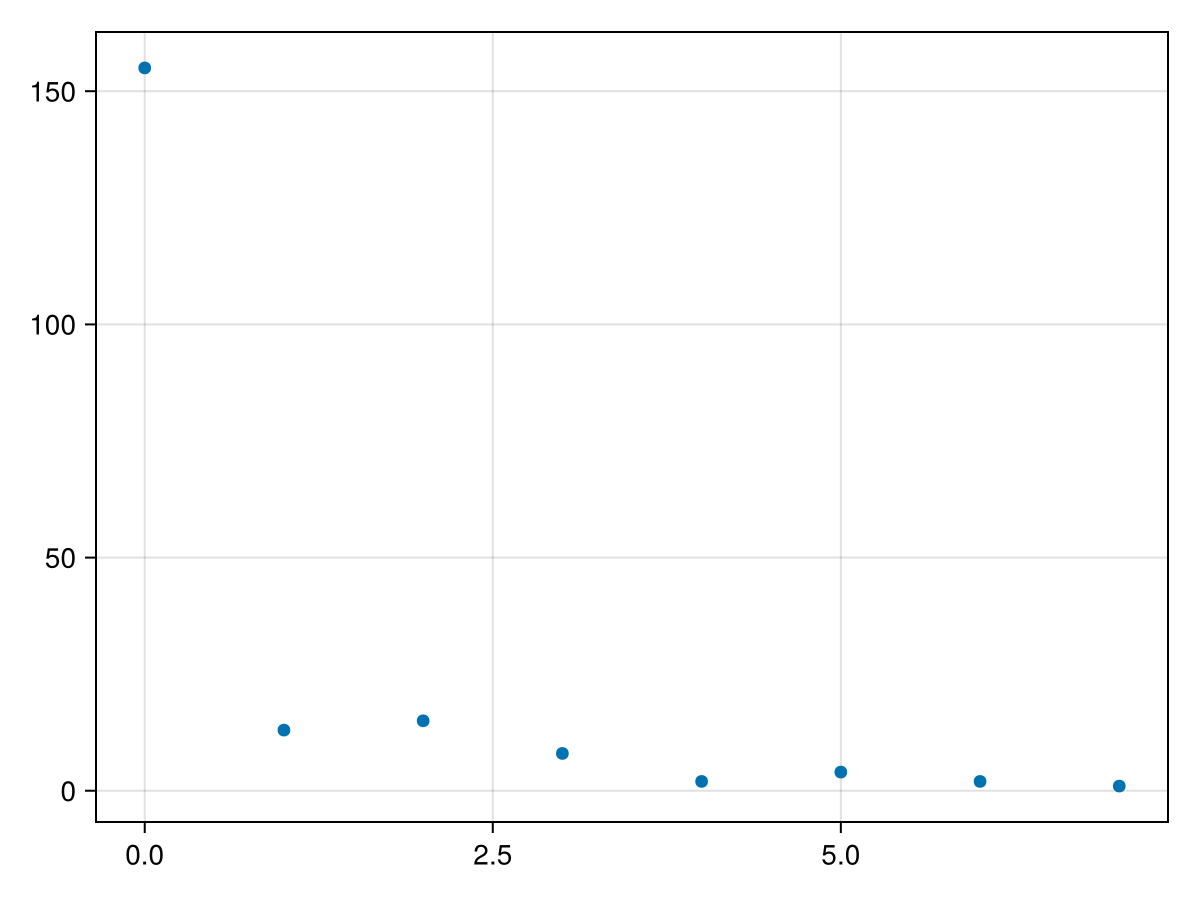

In [32]:
cm = countmap(df.numsurv)
@show cm
nums = sort(collect(keys(cm)))
scatter(nums, [cm[n] for n in nums])

## Selecting runs from that

In [36]:
# Select those with good quality data, that are unstable and have at least 2 surviving species
sdf = @subset(df, 1 .< :numsurv, :good_ss, :good_ls, :lscode .== 2)
nrow(sdf) / nrow(df)

0.11

In [38]:
nrow(sdf)

22

In [37]:
countmap(sdf.numsurv)

Dict{Int64, Int64} with 6 entries:
  5 => 3
  4 => 2
  6 => 1
  7 => 1
  2 => 9
  3 => 6

## Saving for a cluster PDE run

In [437]:
smaller_sdf = sdf[sample(1:nrow(sdf), 1; replace=false),:];

In [435]:
smaller_sdf = @subset(sdf, :numsurv .> 3)
smaller_sdf = smaller_sdf[[6,1,4,2],:]
smaller_sdf.numsurv

4-element Vector{Int64}:
 6
 5
 5
 4

In [436]:
jldsave("./sel_systems2.jld2"; df=smaller_sdf)

## Inspecting ss

In [366]:
sr = rand(eachrow(sdf));

In [393]:
xx = @subset(sdf, :numsurv .== 5)
@show nrow(xx)
sr = xx[1,:];

nrow(xx) = 2


In [394]:
N = md(sdf)["N"]
ps = sr.params
ss = sr.steadystates;
cmin = max(minimum(abs, ss), eps())
css = clamp.(ss, cmin, Inf);

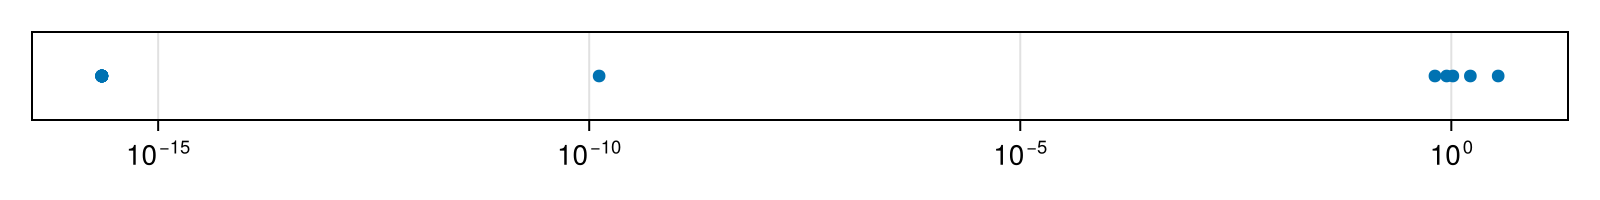

In [395]:
scatter(css[1:N], fill(1, N);
    figure=(; size=(800, 100)),
    axis=(;
        xscale=log10,
        yticks=([], [])
    )
)

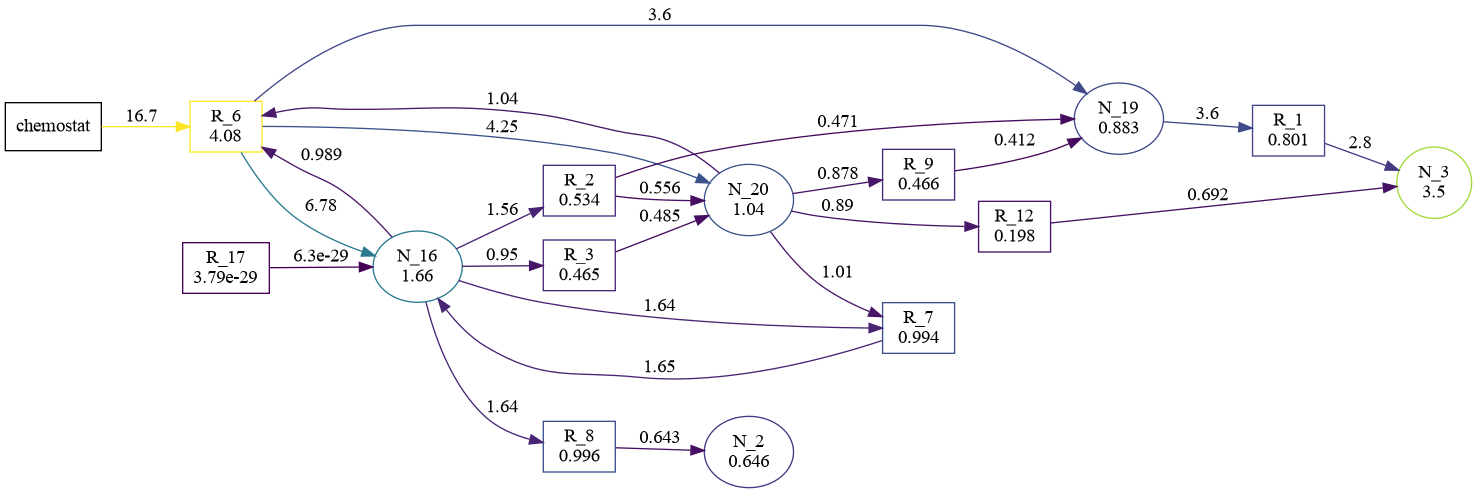

In [398]:
diagram_sfss_v3(ps, ss;
    strain_threshold=1e-2,
    # colorscale=log10,
)

## Plotting full linstab

In [197]:
k_to_evals = linstab_make_k_func(ps, ss)
# ks = 10 .^ range(-5, 3, 100)
ks = range(0.001, 50, 1000)
@time evals = k_to_evals.(ks);

  0.092704 seconds (12.01 k allocations: 35.715 MiB)


[ Info: Unstable, mrl is 0.0142829


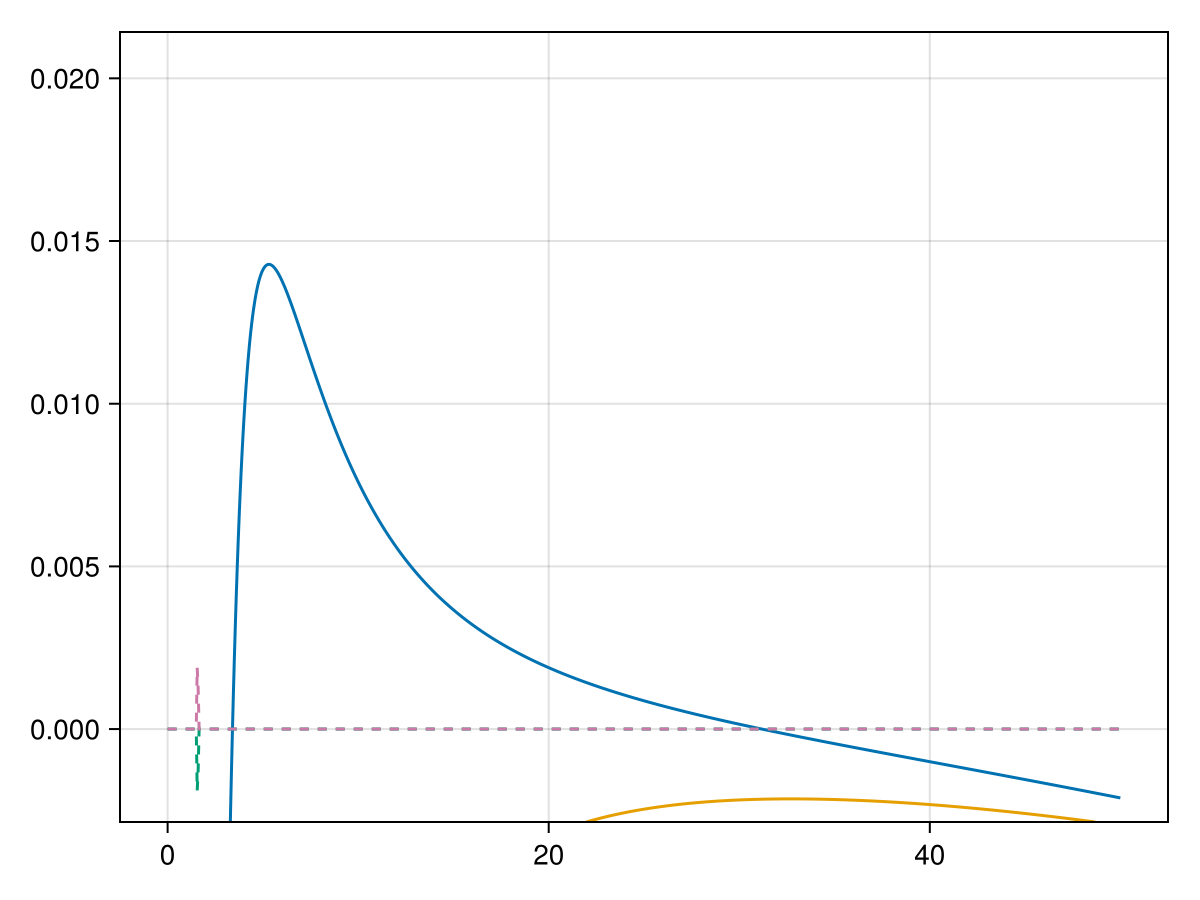

In [198]:
faa = plot_linstab_lambdas(ks, evals;
    axis=(;
        # xscale=log10
    ),
    legend=false
)

# display(GLMakie.Screen(), faa.figure)
faa

# Looking at results

## Testing PDE runner

In [5]:
@time xx = run_1d_pdes_from_df("./sel_systems1.jld2",
    maxtime=60,
);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:26


268.387332 seconds (724.14 M allocations: 146.542 GiB, 6.01% gc time, 6.01% compilation time: 3% of which was recompilation)


In [21]:
N=md(xx, "N"); L=5; sN=5000; dx=L/sN;

In [26]:
xx.final_Ts

4-element Vector{Float64}:
 0.000324407281709338
 0.00014126727389096672
 0.00020708217616851983
 0.00024369755668643438

## Prep

In [18]:
function plot_spatial_fs(u, Ns, sN, dx)
    Nr = size(u)[1] - Ns
    xs = ((1:sN) .- 0.5) .* dx
    
    fig = Figure()
    axs = Axis(fig[1,1])
    axr = Axis(fig[2,1])
    linkxaxes!(axs, axr)

    for i in 1:Ns
        lines!(axs, xs, u[i,:])
    end
    for a in 1:Nr
        lines!(axr, xs, u[Ns+a,:])
    end

    fig
end
# f = plot_spatial_fs(xx.final_states[4], N, dx)
# display(GLMakie.Screen(), f)
# f

plot_spatial_fs (generic function with 2 methods)

In [19]:
f = jldopen("./rslt_df1.jld2")
df = copy(f["df"])
close(f)

N = md(df, "N")
M = md(df, "M")
sN = md(df, "sN")
dx = md(df, "dx")

N, M

(20, 20)

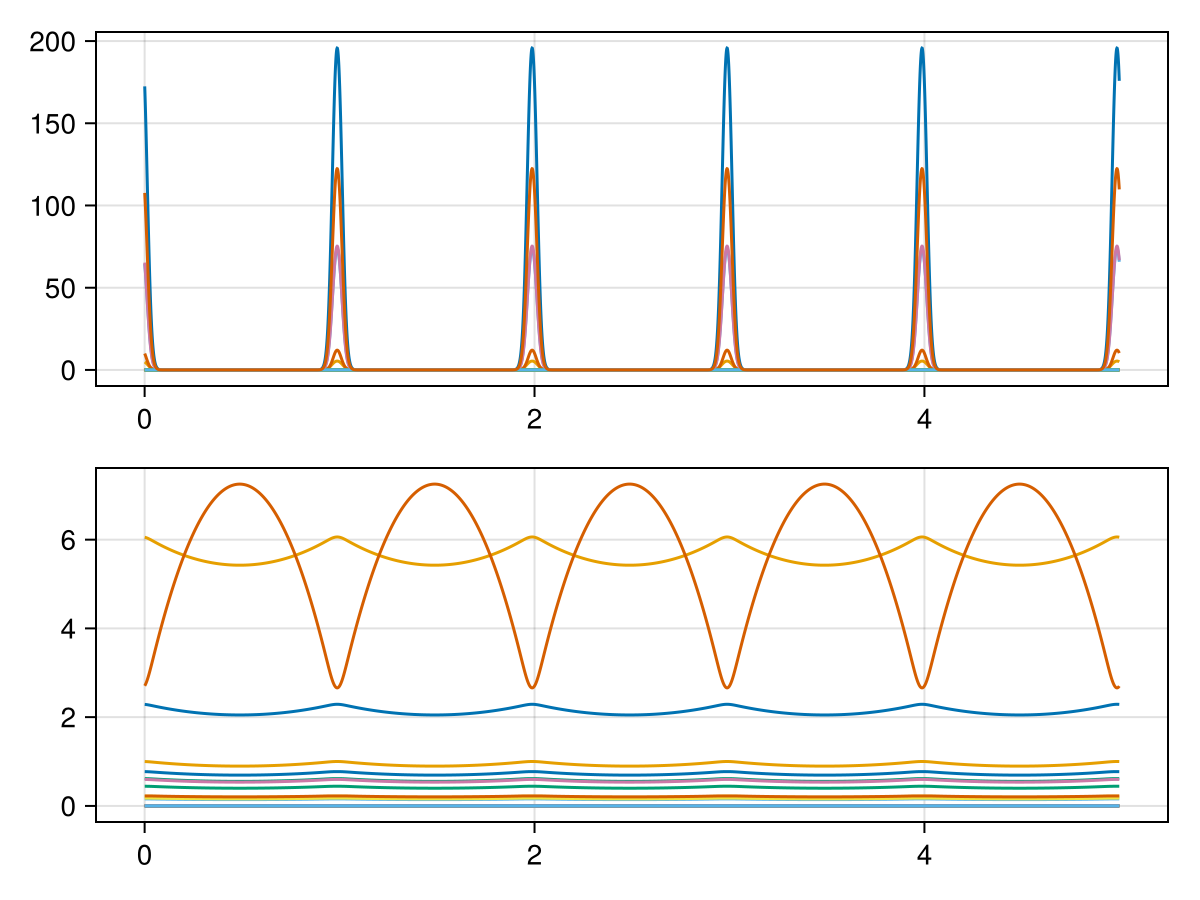

In [28]:
plot_spatial_fs(df.final_states[1], N, sN, dx)

# Progress Callback

In [39]:
using DifferentialEquations
using CairoMakie

In [40]:
using JLD2

In [44]:
typeof(Progress(100))

Progress

In [64]:
mutable struct ProgressCallback
    prog::Union{Nothing,Progress}
    dt::Float64
    next_t::Float64
    function ProgressCallback(T; t0=0.)
        dt = (T - t0) / 1000
        new(nothing, dt, t0)
    end
end
function init_progress!(pc)
    pc.prog = Progress(1000)
end
function update_progress!(pc, t)
    if t > pc.next_t
        next!(pc.prog)
        pc.next_t += pc.dt
    end
    false
end
function finish_progress!(pc)
    finish!(pc.prog)
end

function make_progress_callback(T; t0=0.)
    pc = ProgressCallback(T; t0)
    DiscreteCallback(
        (u, t, i) -> update_progress!(pc, t),
        i -> nothing;
        initialize=(c, u, t, i) -> init_progress!(pc),
        finalize=(c, u, t, i) -> finish_progress!(pc)
    )
end

make_progress_callback (generic function with 1 method)

In [85]:
p = ODEProblem(rand(2) .* 100, (0, 100)) do du, u, t, p
    sleep(0.01)
    du .= -2 .* u
    du .= (rand(2) .- 0.5) .* 0.1
end
# @time s = solve(p, Euler();
@time s = solve(p;
    dt=0.1,
    callback=CallbackSet(make_timer_callback(10), make_progress_callback(100))
);
s.t[end]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 10.175654 seconds (923.83 k allocations: 63.429 MiB, 2.33% compilation time)


68.8231218877584

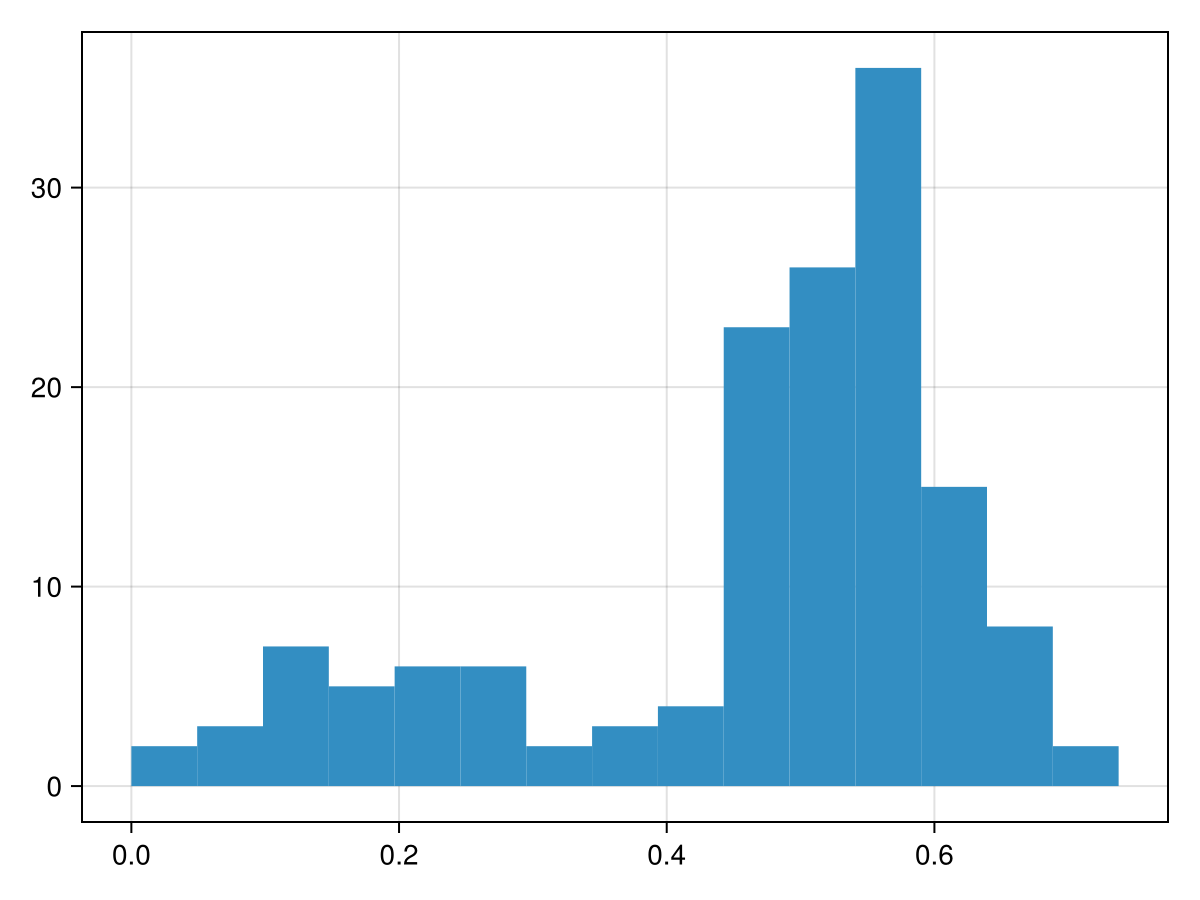

In [87]:
hist(s.t[2:end] .- s.t[1:end-1])

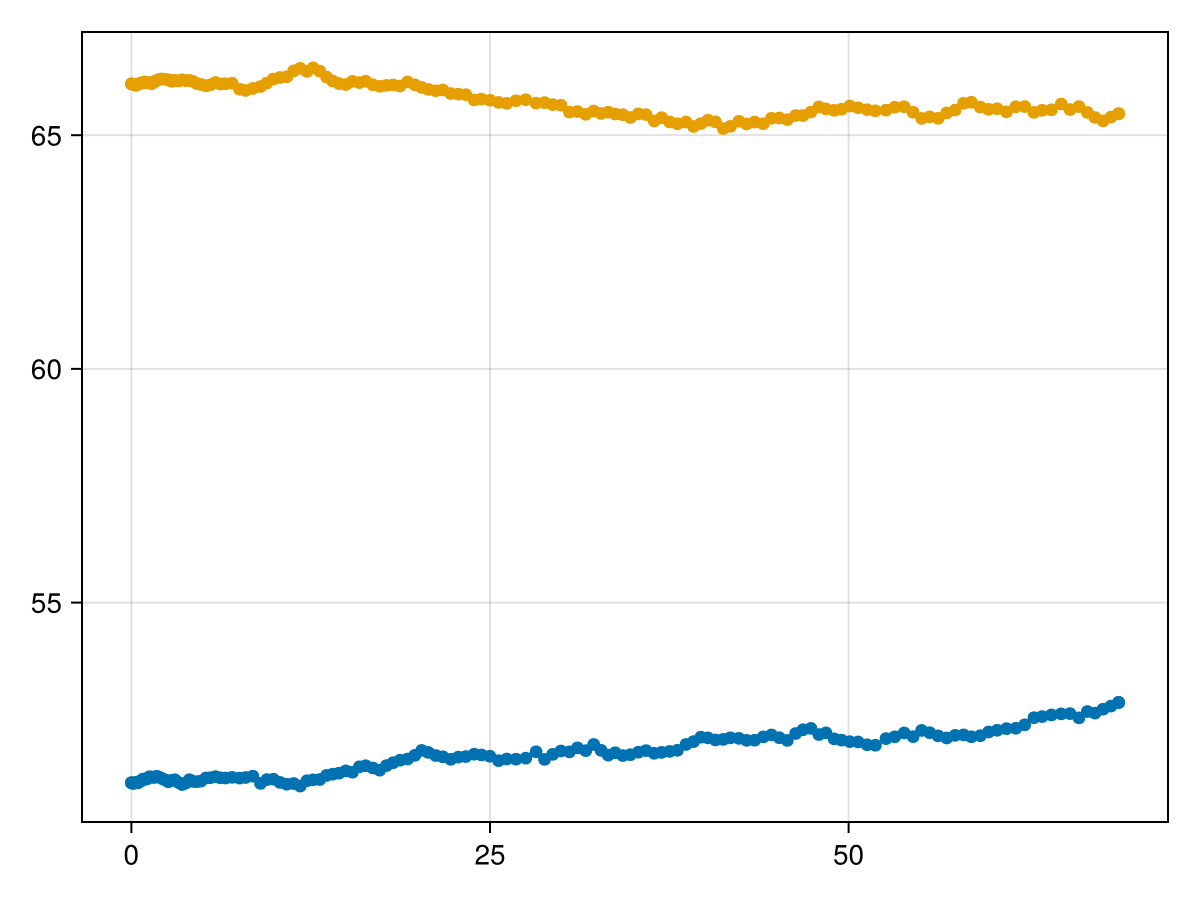

In [86]:
fap = scatterlines(s.t, getindex.(s.u, 1))
scatterlines!(s.t, getindex.(s.u, 2))
fap